<a href="https://colab.research.google.com/github/inferno-D-Ace/AIML_Project_and_Labs/blob/main/AIML_Module_4_Lab_2_Introduction_to_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Training Program on AIML**
# Module 4: Perceptron and Gradient Descent
## Lab 2: Introduction to Gradient Descent

Gradient descent is a very important algorithm to understand, as it underpins many of the more advanced algorithms used in Machine Learning and Deep Learning.

A brief overview of the algorithm is


*   start with a random initialization of the solution.
*   incrementally change the solution by moving in the direction of negative gradient of the objective function.
*   repeat the previous step until some convergence criteria is met.

The key equation for change in weight is:
$$w^{k+1} \leftarrow w^k - \eta \Delta J$$



In [1]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)

We can start be choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [14]:
import numpy as np

def eval_2nd_degree(coeffs, x):
    """Evaluates a second-degree polynomial at x."""
    return coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

# Generate data
hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, 0, 0]

# Vectorized computation
xs = hundred_xs
ys = eval_2nd_degree(coeffs, xs)  # Works with arrays!

# Alternatively, compute directly without the function:
# ys = coeffs[0] * (xs ** 2) + coeffs[1] * xs + coeffs[2]

print("x values:", xs)
print("y values:", ys)

x values: [-9.37141629  2.72820823 -3.71288038  0.17141382  8.15132948 -5.01415542
 -1.79234154  5.11102277 -5.42403669 -8.4604018  -4.20497094 -6.77557425
  8.59395305  6.16240759  2.66807513  7.4292118   6.07344154 -6.26859882
  7.85117997  0.78684484  6.1488031   7.921826   -3.6399305  -7.79896151
 -5.44129675 -1.45784423  6.36029532  7.21461167 -9.86095739  0.21494605
 -1.65177994 -5.55784379 -7.60269265 -3.24769657  8.85819408 -3.53594136
  0.37581243  4.06037918 -2.72740795  9.43564165  9.2489459  -4.96435408
 -0.05502988 -3.9824338  -4.30319011 -9.26226105  2.19128668  0.05358046
 -8.97042498 -4.42707072  8.16531772 -5.20876219 -7.10210256 -0.21094479
  9.71300908 -5.15889457  3.44271095  5.23239231 -5.24724912  4.56432697
 -2.64433735  2.64611661  2.67059422  0.71549368 -8.1942046   6.70604991
 -3.5843987  -6.26962979 -9.18449717  1.81785886  3.55128724 -9.66824342
  0.24186117 -5.4700845   2.90345581 -6.51267142  3.81875476 -2.26529307
  8.73459977 -7.24958112 -3.17867298 -7.7

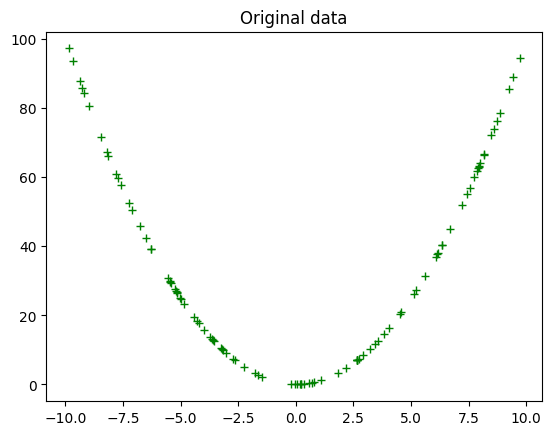

In [15]:
plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [16]:
import numpy as np

# Define coefficients and jitter parameter
coeffs = [1, 0, 0]
j = 0.1

# Generate 100 random x values
hundred_xs = np.random.uniform(-10, 10, 100)

# Compute y = ax² + bx + c (vectorized)
ys = coeffs[0] * (hundred_xs ** 2) + coeffs[1] * hundred_xs + coeffs[2]

# Generate jittered values within [y−j, y+j] (vectorized)
random_offsets = np.random.uniform(-j, j, size=hundred_xs.shape)
jittered_ys = ys + random_offsets

# Assign xs and ys (no loops needed)
xs = hundred_xs  # Already a NumPy array
ys = jittered_ys  # Jittered values

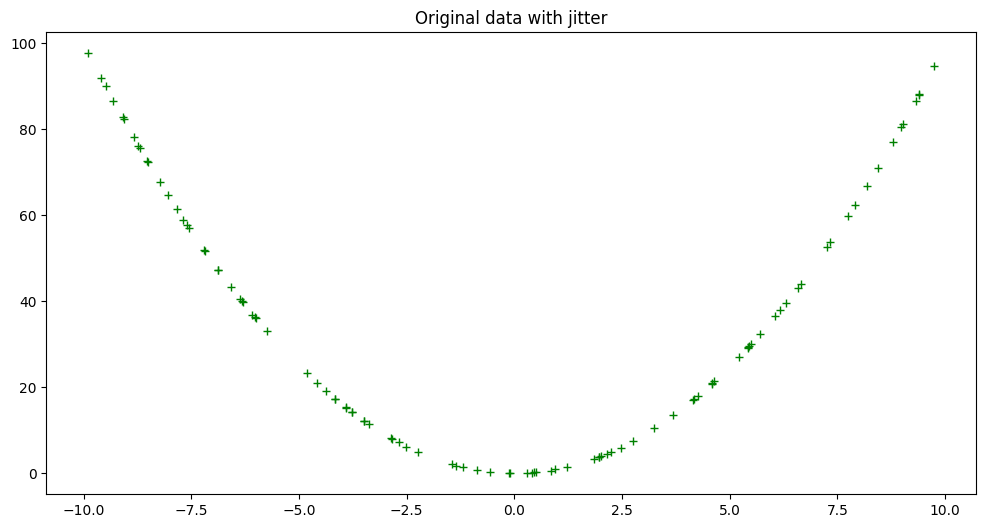

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [6]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.

    Args:
        ys: training data labels
        y_bar: prediction labels

    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

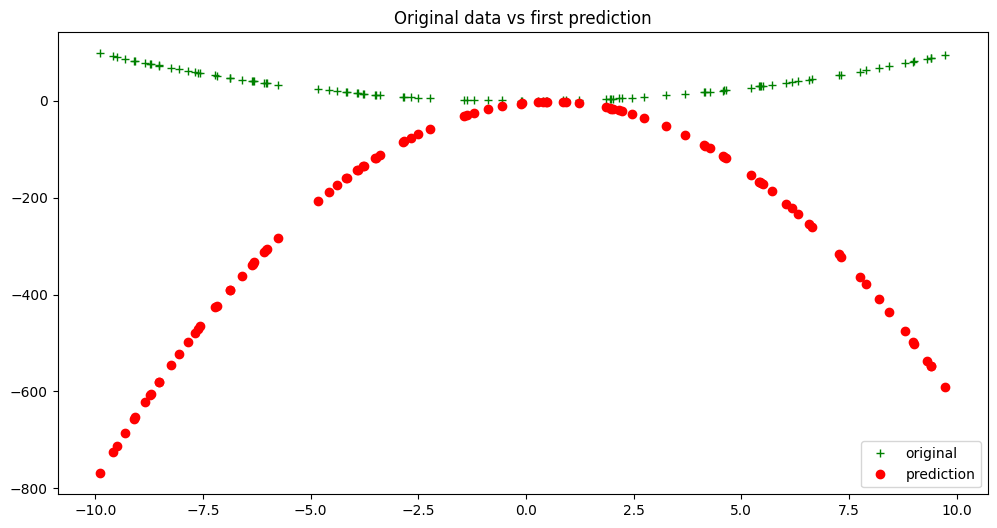

In [7]:
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar, 'ro', label = 'prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [8]:
initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

np.float64(146807.86204726336)

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [9]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """

    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

In [10]:
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

lr = 0.0001
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new)
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (np.float64(-3.4872074852403587), np.float64(7.879149056895183), np.float64(-4.941405407033594))
Now have smaller model loss: 49608.172144854274 vs 146807.86204726336


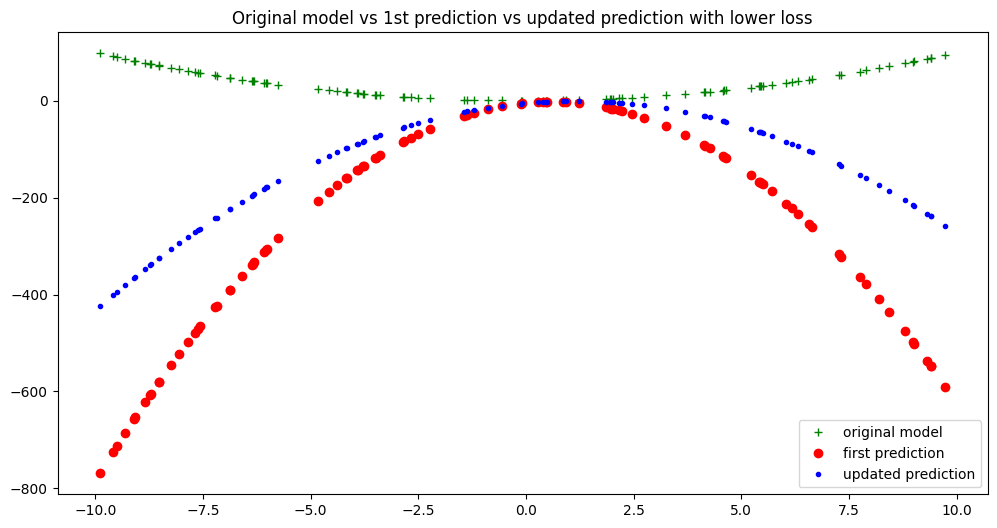

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original model')
plt.plot(xs, y_bar, 'ro', label = 'first prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [12]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [20]:
import numpy as np

def gradient_descent(epochs, lr, X, y, initial_coeffs):
    """
    Vectorized gradient descent for 2nd degree polynomial regression

    Args:
        epochs: Number of iterations
        lr: Learning rate
        X: Input features (vector)
        y: Target values (vector)
        initial_coeffs: Initial coefficients [a, b, c]

    Returns:
        tuple: (final_loss, final_coeffs, predictions, loss_history)
    """
    # Convert to numpy arrays for vector operations
    coeffs = np.array(initial_coeffs, dtype=np.float64)
    X_sq = X ** 2
    N = len(X)

    loss_history = []

    for _ in range(epochs):
        # Vectorized predictions
        y_pred = coeffs[0] * X_sq + coeffs[1] * X + coeffs[2]

        # Compute error vector
        error = y_pred - y

        # Vectorized gradient calculations
        grad_a = (2/N) * np.dot(X_sq, error)
        grad_b = (2/N) * np.dot(X, error)
        grad_c = (2/N) * np.sum(error)

        # Update coefficients
        coeffs[0] -= lr * grad_a
        coeffs[1] -= lr * grad_b
        coeffs[2] -= lr * grad_c

        # Calculate and store MSE
        mse = np.mean(error ** 2)
        loss_history.append(mse)

    # Final predictions with optimized coefficients
    final_pred = coeffs[0] * X_sq + coeffs[1] * X + coeffs[2]

    return mse, coeffs, final_pred, loss_history

In [26]:
GD = gradient_descent(30000, 0.0003, xs, ys, rand_coeffs) # Pass xs, ys, and rand_coeffs to the gradient_descent function

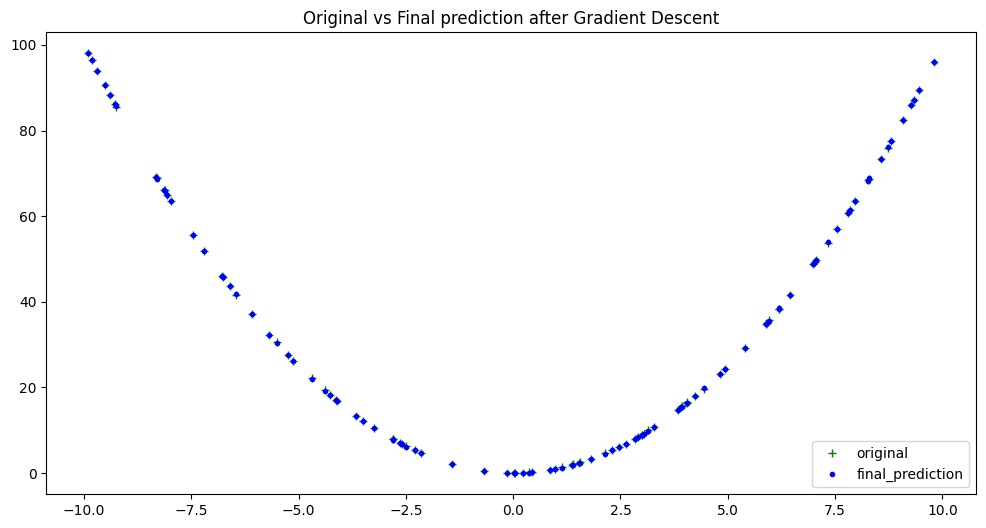

In [27]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [28]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: [ 1.00015993 -0.00209542 -0.00731751]
Original Coefficients: [1, 0, 0]


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


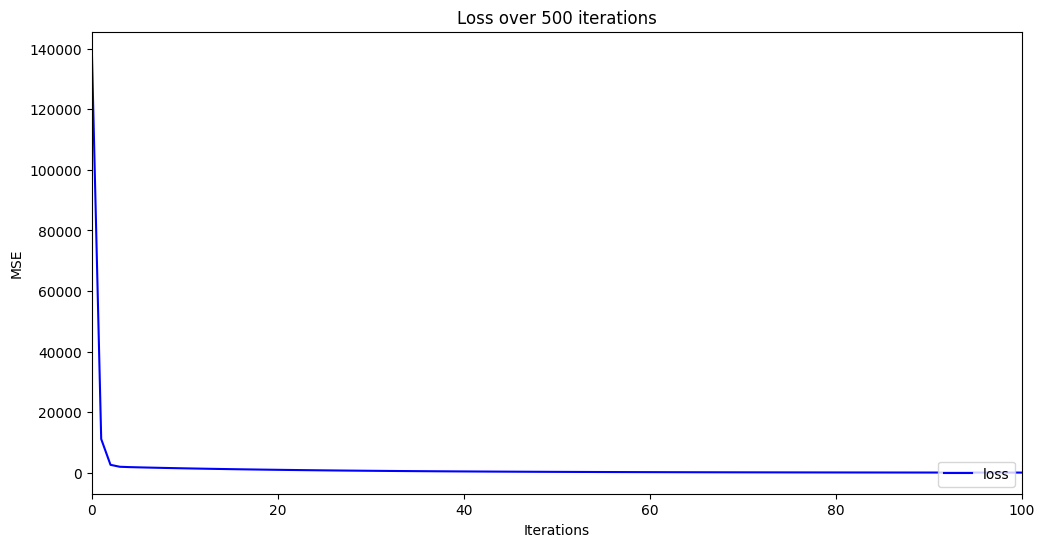

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
# plt.xlim(0,50)
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlim((0,100))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss after about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached. This would prevent excessive training and potential over-fitting for the model.

# Things to try



1.   Change the coefficients array and try a different polynomial instead of our $x^2$.
2.   Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?
3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?
4. Can you modify the algorithm to find a maxima of a function, instead of a minima?



## **Additional Critical Thinking Questions**

1. You are doing full batch gradient descent using the entire training set. Is it necessary to shuffle the training data? Explain your
answer.

2. You would like to train a dog/cat image classifier using mini-batch gradient
descent. You have already split your dataset into train, dev and test sets. The classes
are balanced. You realize that within the training set, the images are ordered in such a
way that all the dog images come first and all the cat images come after. A friend tells
you: ”you absolutely need to shuffle your training set before the training procedure.”
Is your friend right? Explain.